In [2]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import re
import matplotlib.pyplot as plt
import time
import seaborn as sns
from nltk.probability import FreqDist
%matplotlib inline

In [3]:
df1 = pd.read_csv('yearly_articles/apple2020.csv', index_col=0)
df2 = pd.read_csv('yearly_articles/apple2019.csv', index_col=0)
df3 = pd.read_csv('yearly_articles/apple2018.csv', index_col=0)
df4 = pd.read_csv('yearly_articles/apple2017.csv', index_col=0)
df5 = pd.read_csv('yearly_articles/apple2016.csv', index_col=0)
df6 = pd.read_csv('yearly_articles/apple2015.csv', index_col=0)
df = pd.concat([df1,df2, df3, df4, df5, df6])
df.dropna(subset=['fulltext'], inplace=True)
df.shape

(39512, 7)

# Clean newlines and special characters

In [4]:
def clean_text(text):
    text.replace("\n"," ")
    text =  ' '.join(re.sub("([^0-9A-Za-z])"," ",text).split())
    return text.lower()

In [5]:
%%time
df['cleaned_text'] = df['fulltext'].apply(clean_text)
df['cleaned_authors'] = df['author'].apply(clean_text)

CPU times: user 10.6 s, sys: 299 ms, total: 10.9 s
Wall time: 11.1 s


#### Changing the UTC time to EST.

In [6]:
import pytz

In [7]:
#Change to Datetime
df["date"]= pd.to_datetime(df["date"])
df = df.set_index('date')
df.index = df.index.normalize()

In [8]:
%%time
#convert DateTime index to eastern time. 
eastern = pytz.timezone('US/Eastern')
df.index = df.index.tz_convert(eastern).tz_localize(None)
#put into year/month/day format
df.index = df.index.strftime('%Y-%m-%d')

CPU times: user 254 ms, sys: 8.8 ms, total: 263 ms
Wall time: 272 ms


# Using [tldextract](https://pypi.org/project/tldextract/) to extract company names from url's

In [9]:
import tldextract

In [10]:
def get_outlet(link):
    res = tldextract.extract(link)
    return res.domain

In [11]:
%%time
df['news_outlet'] = df['source'].apply(get_outlet)
print('The dataset contains {} different articles from {} news outlets \n'.format(df.shape[0],df.news_outlet.nunique()))

The dataset contains 39512 different articles from 448 news outlets 

CPU times: user 490 ms, sys: 16.7 ms, total: 506 ms
Wall time: 555 ms


# Getting historical Stock Prices

In [ ]:
from twelvedata import TDClient
td = TDClient(apikey="ef26202dacaf412fb157a05403f81ca3") 

In [ ]:
def get_month_day_range(year):
    ranges = []
    year = [(pd.datetime(year,1,1)), (pd.datetime(year,2,1)), (pd.datetime(year,3,1)),
           (pd.datetime(year,4,1)), (pd.datetime(year,5,1)), (pd.datetime(year,6,1)),
           (pd.datetime(year,7,1)), (pd.datetime(year,8,1)), (pd.datetime(year,9,1)),
           (pd.datetime(year,10,1)), (pd.datetime(year,11,1)), (pd.datetime(year,12,1))]
    for date in year:
        last_day = date + relativedelta(day=1, months=+1, days=-1)
        first_day = date + relativedelta(day=1)
        ranges.append((first_day.strftime('%Y-%m-%d'), last_day.strftime('%Y-%m-%d')))
    return ranges

months_2020 = get_month_day_range(2020)
months_2020

In [ ]:
months_2018 = get_month_day_range(2010)
months_2018

In [ ]:
times = []

In [ ]:
#Gather historical data from twelvedata API
counter =1
for start,end in months_2018:
    time.sleep(25)
    ts = td.time_series(
    symbol="AAPL",
    interval="1day",
    start_date=start,
    end_date=end
    ).as_pandas()
    times.append(ts)
    print(counter, start,end)
    counter +=1
    

In [ ]:
stock_prices_appl = pd.concat(times)

In [ ]:
#Normalize the datetime indexes
stock_prices_appl
stock_prices_appl.index = stock_prices_appl.index.normalize()

In [ ]:
#Merge prices and main df's on the date
merge=pd.merge(df,stock_prices_appl, how='outer', left_index=True, right_index=True)

In [ ]:
#localize the price df
stock_prices_appl.index = stock_prices_appl.index.tz_localize(None)

In [ ]:
stock_prices_appl['day_change'] = np.nan
stock_prices_appl['increase'] = np.nan

In [ ]:
prices_index = stock_prices_appl.index.strftime('%Y-%m-%d').to_list()

In [ ]:
df_res = pd.DataFrame(columns = ['day_change', 'increase', 'date'])
for i,stock_price in enumerate(prices_index):
    try:
        start = stock_prices_appl.loc[prices_index[i]].open[0]
        stop = stock_prices_appl.loc[prices_index[i+1]].open[0]
        direction = start - stop
        if direction < 0:
            increase = 0
        else:
            increase = 1
        df_res = df_res.append({'day_change': direction, 'increase':increase, 'date':stock_price}, ignore_index=True)
    except:
        continue

In [ ]:
df_res["date"]= pd.to_datetime(df_res["date"])
df_res = df_res.set_index('date')
df_res.index = df_res.index.normalize()

In [ ]:
targets2020 = df_res.shift(periods=1, fill_value=0)
targets2020.head()

In [ ]:
targets2020.to_csv('yearly_targets/targets2010.csv')

# Predict Sentiment for each Article with VADER

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [13]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(article):
    '''
    VADER Sentiment used to tag the.
    Returns the predicted labels: positive/negative/neutral.
    Instantiate analyzer before running this function:
    analyzer = SentimentIntensityAnalyzer()
    '''
    global analyzer

    score = analyzer.polarity_scores(article)

    if score['compound'] >= .05:
        sent = 'positive'
    elif score['compound'] <= -.05:
        sent = 'negative'
    else:
        sent = 'neutral'

    return sent

In [14]:
%%time
df['sentiment'] = df['fulltext'].apply(sentiment_analyzer_scores)

CPU times: user 13min 58s, sys: 15.6 s, total: 14min 14s
Wall time: 14min 33s


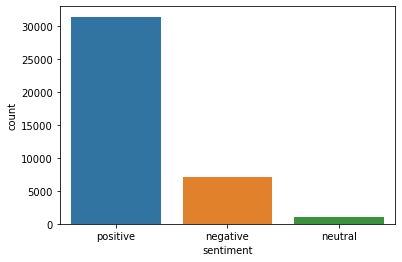

In [15]:
sns.countplot(df.sentiment);

In [ ]:
# for i,art in enumerate(df.cleaned_text[:200]):
#     score = sentiment_analyzer_scores(art)
#     print(i, score)

# Tokenize

In [16]:
from nltk.tokenize import regexp_tokenize 

def toke(text):
    tokens = regexp_tokenize(text, "[\w']+")
    return tokens

df['tokens'] = df['cleaned_text'].apply(toke)

# Lemmatize 

In [17]:
import nltk
from nltk.corpus import stopwords

In [18]:
def unlist(x):
    return ", ".join(x)

In [19]:
tokenizer = nltk.tokenize.TweetTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words=list(set(stopwords.words("english")))



def tokenize(text):
    return nltk.word_tokenize(text)
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]
def lemmatize_text(text):
     return [lemmatizer.lemmatize(word) for word in text]

In [20]:
df.tokens = df.tokens.apply(remove_stopwords)

In [21]:
df.tokens = df.tokens.apply(lemmatize_text)

In [22]:
df.tokens = df.tokens.apply(unlist)

# Frequency Dict

In [23]:
filt = df.tokens

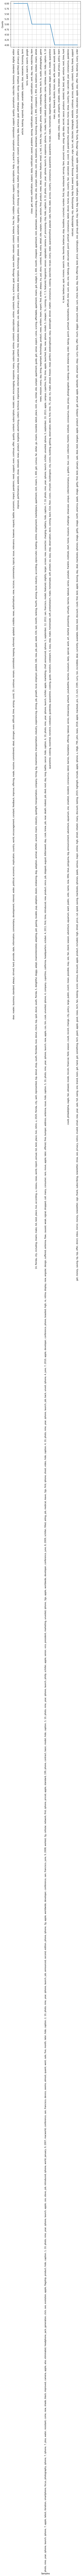

In [24]:
fdist=FreqDist(filt)
fdist.plot(15);

# TFIDF

In [127]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer 

rf_feats = df.tokens.values
tfidfconverter = TfidfVectorizer(max_features=10000, ngram_range=(1,3))  

X = tfidfconverter.fit_transform(rf_feats).toarray()

tfidf_df = pd.DataFrame(X)

CPU times: user 1min 45s, sys: 8.18 s, total: 1min 53s
Wall time: 1min 59s


In [128]:
df = df.reset_index()
frames = [df, tfidf_df]
main_df = pd.concat(frames, axis=1) 

In [129]:
main_df.to_csv('main_data/maindf.csv')

In [63]:
main_df.head()

,index,update,source,author,fulltext,summary,title,cleaned_text,cleaned_authors,news_outlet,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,2020-08-17,NaN,https://gizmodo.com/apple-renames-apple-beats-...,[],Photo : JOSH EDELSON/AFP ( Getty Images )\n\nA...,NaN,"Apple Renames Apple Beats 1 Apple Music 1, Not...",photo josh edelson afp getty images apple toda...,,gizmodo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-08-16,2020-08-17 21:20:26+01:00,https://www.dailymail.co.uk/sciencetech/articl...,"['Stacy Liberatore', 'Stacy Liberatore For Dai...",Apple retaliated against Epic Games after bein...,NaN,Apple bans Epic Games from App store after ant...,apple retaliated against epic games after bein...,stacy liberatore stacy liberatore for dailymai...,dailymail,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-08-13,2020-08-14 19:52:00+00:00,https://www.wbaltv.com/article/fortnite-s-make...,"['Brian Fung', 'Shannon Liao']",Hide Transcript Show Transcript\n\nThe company...,NaN,Fortnite's maker sues Apple and Google after t...,hide transcript show transcript the company be...,brian fung shannon liao,wbaltv,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-08-12,NaN,https://www.business-standard.com/article/comp...,['Mark Gurman'],Inc. is readying a series of bundles that will...,NaN,Apple likely to unveil subscription bundles to...,inc is readying a series of bundles that will ...,mark gurman,business-standard,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-08-12,2020-08-13 00:00:00,https://decider.com/2020/08/13/apple-plans-dig...,[],Apple is about to make it much easier — and le...,NaN,Apple Reportedly Bundling Apple TV+ With Apple...,apple is about to make it much easier and less...,,decider,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
df.groupby(df.index).sum()

,summary
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
33445,0.0
33446,0.0
33447,0.0
33448,0.0


In [105]:
df.head()

,index,update,source,author,fulltext,summary,title,cleaned_text,cleaned_authors,news_outlet,sentiment,tokens
0,2020-08-17,NaN,https://gizmodo.com/apple-renames-apple-beats-...,[],Photo : JOSH EDELSON/AFP ( Getty Images )\n\nA...,NaN,"Apple Renames Apple Beats 1 Apple Music 1, Not...",photo josh edelson afp getty images apple toda...,,gizmodo,positive,"photo, josh, edelson, afp, getty, image, apple..."
1,2020-08-16,2020-08-17 21:20:26+01:00,https://www.dailymail.co.uk/sciencetech/articl...,"['Stacy Liberatore', 'Stacy Liberatore For Dai...",Apple retaliated against Epic Games after bein...,NaN,Apple bans Epic Games from App store after ant...,apple retaliated against epic games after bein...,stacy liberatore stacy liberatore for dailymai...,dailymail,positive,"apple, retaliated, epic, game, served, anti, t..."
2,2020-08-13,2020-08-14 19:52:00+00:00,https://www.wbaltv.com/article/fortnite-s-make...,"['Brian Fung', 'Shannon Liao']",Hide Transcript Show Transcript\n\nThe company...,NaN,Fortnite's maker sues Apple and Google after t...,hide transcript show transcript the company be...,brian fung shannon liao,wbaltv,negative,"hide, transcript, show, transcript, company, b..."
3,2020-08-12,NaN,https://www.business-standard.com/article/comp...,['Mark Gurman'],Inc. is readying a series of bundles that will...,NaN,Apple likely to unveil subscription bundles to...,inc is readying a series of bundles that will ...,mark gurman,business-standard,positive,"inc, readying, series, bundle, let, customer, ..."
4,2020-08-12,2020-08-13 00:00:00,https://decider.com/2020/08/13/apple-plans-dig...,[],Apple is about to make it much easier — and le...,NaN,Apple Reportedly Bundling Apple TV+ With Apple...,apple is about to make it much easier and less...,,decider,positive,"apple, make, much, easier, le, expensive, subs..."
